## Exercise 5: Variance reduction methods Exercise 

In this exercise 5 we use variance reduction methods to obtain better estimates of the integral of $e^{ x }$
from 0 to 1. Here from part 1 to part 4 we applied crude Monte Carlo, antithetic variables, control variable and stratified sampling. 

The t-distribution with alpha = 0.95 and n-1
degrees of freedom is used in all methods to obtain the CI. In all cases we use n = 100. 

In part 5 we have we used the control variates method to reduce the blocking ratio of the poisson arival time in our previous exercise 4. 

Further the control variates method is used to reduce the variance of the blocking ratio in
exercise 4 in the case of Poisson distributed arrival times.



In [16]:
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import time


In [17]:
U = np.random.uniform(0,1,100)

# 1

In [18]:
def crude_monte_carlo_estimator(u):
    n = len(u)
    X = np.exp(u)
    mean = np.mean(X)
    
    S_square = (1/(n-1)) * (np.sum(np.multiply(X, X)) - n * mean ** 2)
    S = math.sqrt(abs(S_square))
    monte_conf_interval = [mean + (S / math.sqrt(n)) * stats.t.ppf(0.025, n-1), mean + (S / math.sqrt(n)) * stats.t.ppf(1-0.025, n-1)]
    print('The point estimate of the crude  Monte Carlo estimator is: {} with confidence interval {}'.format(mean, monte_conf_interval))


In [19]:
crude_monte_carlo_estimator(U)

The point estimate of the crude  Monte Carlo estimator is: 1.7753951067696905 with confidence interval [1.6702131774318036, 1.880577036107577]


# 2

In [20]:
def antithetic_variables(u):
    n = len(u)
    Y = (np.exp(u) + np.e / np.exp(u)) / 2
    Ybar = np.mean(Y)

    X1 = np.exp(u)
    X1bar = np.mean(X1)
    X1var = np.var(X1)

    u1 = 1 - np.array(u)
    X2 = np.exp(u1)
    X2bar = np.mean(X2)
    X2var = np.var(X2)

    Yvar = 0.5 * (X1var + np.e - X1bar * X2bar)
    Ybar_conf = 1.96 * math.sqrt(abs(Yvar)) / math.sqrt(n)
    ant_conf_interval = [Ybar - Ybar_conf, Ybar + Ybar_conf]
    print('The point estimate of the Antithetic variables is: {} and confidence interval {}'.format(Ybar, ant_conf_interval))


In [21]:
antithetic_variables(U) 

The point estimate of the Antithetic variables is: 1.724459097386091 and confidence interval [1.702412097825431, 1.746506096946751]


# 3

In [54]:
def control_variables(u):
    n = len (u)
    X = np.exp(u)
    Y = u
    Yminus_half = []
    for x in Y:
        Yminus_half.append(x - 0.5)
    
    XY = np.multiply(X,Y)
    Xmean, Xvar = np.mean(X), np.var(X)
    Ymean, Yvar = np.mean(Y), np.var(Y)
    XYmean, XYvar = np.mean(XY), np.var(XY)
    Cov_XY = XYmean - Xmean * Ymean
    c = -Cov_XY / Yvar
    
    Z = X + np.multiply(c,Yminus_half)
    Zmean = sum(Z)/n
    Zvar = Xvar - (Cov_XY **2/Yvar)
    
    
    Zmean_conf = 1.96 * math.sqrt(Zvar)/math.sqrt(n)
    control_conf_interval = [Zvar - Zmean_conf, Zmean + Zmean_conf]
    
    print('The point estimate of the Control variables is: {} with confidence interval {}'.format(Zmean, control_conf_interval))
    


In [57]:
control_variables(U)

The point estimate of the Control variables is: 1.7238835505014531 with confidence interval [-0.008653576210755182, 1.7370490774739893]


# 4


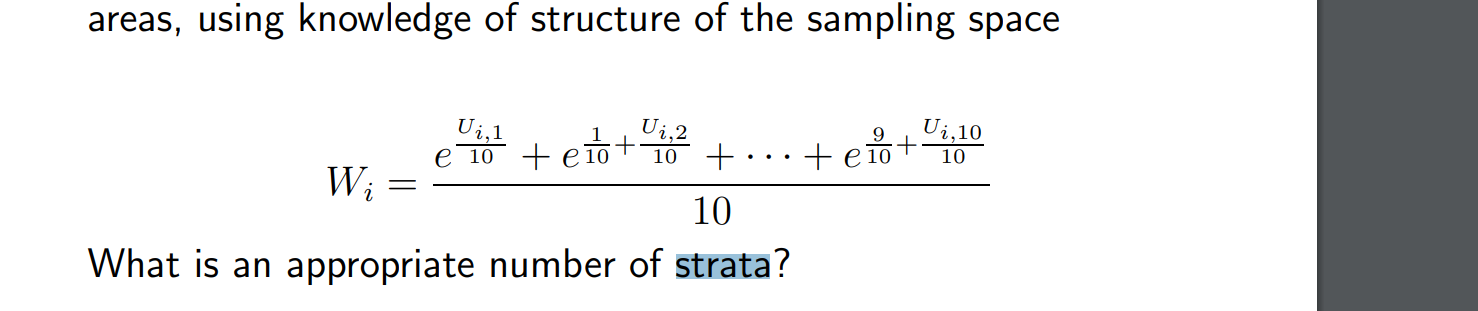

In [113]:

def stratified_sampling(n, strata):
    W = []
    for _ in range(n):
        u = np.random.uniform(0, 1, strata)
        temp = 0
        for j in range(strata):
            temp = temp + np.exp((j+1)/strata + u[j]/strata)
        W.append(temp/strata)
        
#    print(W)

    Wmean, Wvar = np.mean(W), np.var(W)

    Zmean_conf = 1.96 * math.sqrt(Wvar) / math.sqrt(n)
    stratified_conf_interval = [Wmean - Zmean_conf, Wmean + Zmean_conf]

    print('The point estimate of the Stratified sampling is: {} with confidence interval {}'.format(Wmean, stratified_conf_interval))

    plt.hist(W, bins=30)
    plt.show()

The point estimate of the Stratified sampling is: 1.8989356662025065 with confidence interval [1.8954199624329522, 1.9024513699720609]


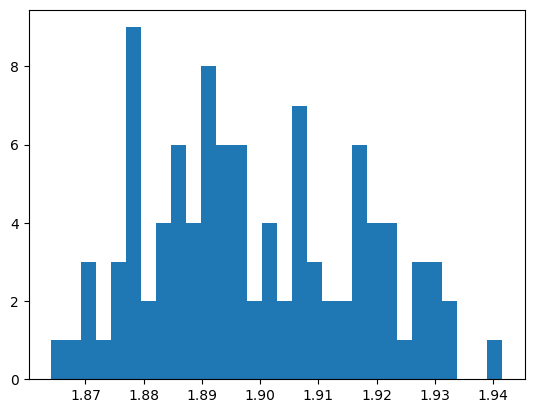

In [118]:
stratified_sampling(100, 10)


# 5

In [11]:
def simulate_poisson(N):
    service_mean = 8
    service_number = 10
    lambd = 1
    customer_number = 10000
    blocked_probability =[]
    for i in range(N):
        service_times = np.empty(0,dtype = 'float64')
        blocked_customers = 0
        time = 0.0
        for i in range(customer_number):
            interval = np.random.exponential(scale=lambd, size=1)
            time += interval
            service_times= service_times[service_times >time]
        
            if (len(service_times)<service_number):
                service_interval = np.random.exponential(scale=service_mean)
                service_times = np.append(service_times,time+service_interval)
            else:
                blocked_customers += 1
        #blocked_probability = float(blocked_customers/customer_number)
        blocked_probability.append(float(blocked_customers/customer_number))
        
    return blocked_probability

    


In [14]:
def control_variable(u):
    n = len(u)
    X = np.exp(u)
    #print(X)
    Y = u
    Yminus_half = []
    for x in Y:
        Yminus_half.append(x - 0.5)
    
    XY = np.multiply(X,Y)
    Xmean, Xvar = np.mean(X), np.var(X)
    Ymean, Yvar = np.mean(Y), np.var(Y)
    XYmean, XYvar = np.mean(XY), np.var(XY)
    Cov_XY = XYmean - Xmean * Ymean
    c = -Cov_XY / Yvar
    
    Z = X + np.multiply(c,Yminus_half)
    Zmean = np.mean(Z)
    Zvar = Xvar - (Cov_XY **2/Yvar)
    
    
    Zmean_conf = 1.96 * math.sqrt(Zvar)/math.sqrt(n)
    control_conf_interval = [Zvar - Zmean_conf, Zmean + Zmean_conf]
    print("Mean poisson blocking probablity: ",np.mean(u))
    print('Mean blocking of poisson arrival using Control variable is: {} with confidence interval {}'.format(Zmean, control_conf_interval))
    


In [15]:
control_variable(simulate_poisson(10))

Mean poisson blocking probablity:  0.12387
Mean blocking of poisson arrival using Control variable is: 1.557698960339012 with confidence interval [-1.2576137747497285e-05, 1.5577115368884877]
